Нужные импорты

In [1]:
from os import listdir, environ
#environ[KERAS_BACKEND] = "theano"
from keras.applications import InceptionV3
from os.path import join
import numpy as np
# import numpy.core.multiarray 
import cv2
from glob import glob
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


Препроцессинг

In [2]:
def prepare_data(path, size, mode='resize', crop_num=5):
    """
    returns:
    X - np.array of size (samples_num, size, size, 3)
    Y - np.array of size (samples_num,)
    classes - list of str, indices corresponding to numbers in Y
    
    path - str - path to data, each folder in path is separate class
    size - int - desired size of images
    mode - str - 'resize' or 'random_crop'.
                 if 'resize', image is resized to desired size
                 if 'random_crop', several random crops of desired size are extracted from one image
    crop_num - int - number of crops for 'random_crop'
    """
    classes = [cl for cl in sorted(listdir(path)) if cl != '.ipynb_checkpoints']
    X = []
    Y = []
    for i,cl in enumerate(classes):
        for artist in listdir(path+"/"+cl):
            imgs = glob(join(path,cl,artist,'*.jpg'))
            for img in imgs:
                #img_np = cv2.imread(img)
                #img = img.encode("utf-8", "surrogateescape")
                try: 
                    img_np = cv2.imread(img)
                    #print(img.encode("utf-8", "surrogateescape"))
                except Exception as ex:
                    print("problems with image: ", img, ex)    
                if mode == 'resize':
                    try: 
                        img_np = cv2.resize(img_np,(size,size))
                        X.append(img_np)
                        Y.append(i)
                    except:
                        print("problems with image: ", img)
                if mode == 'random_crop':
                    if size > img_np.shape[0] or size > img_np.shape[1]:
                        raise Exception('Image {} is too small for random crop size'.format(img))
                    for _ in range(crop_num):
                        border_0 = np.random.randint(0,img_np.shape[0]-size)
                        border_1 = np.random.randint(0,img_np.shape[1]-size)
                        img_crop = img_np[border_0 : border_0 + size, border_1 : border_1 + size]
                        X.append(img_crop)
                        Y.append(i)
    X = np.array(X)
    Y = np.array(Y)
    return X,Y,classes

In [3]:
X,Y,classes = prepare_data(path='./Pandora_18k/',
                           mode='resize',
                           size = 100)

In [4]:
print(X.shape)
print(Y.shape)
print(classes)

(16943, 100, 100, 3)
(16943,)
['00_PopArt', '01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt']


### Нейроночка
Описание моделек можно найти тут:    
https://keras.io/applications/

Загружаем модель. `include_top=False`, потому что мы не хотим предсказывать классы, нам нужен предыдущий слой

In [5]:
environ["https_proxy"] = "https://proxy-mu.intel.com:911"
model = InceptionV3(include_top=False,weights='imagenet')

Прогоняем данные через сетку

In [6]:
pred = model.predict(X)

In [7]:
print(pred.shape)

(16943, 1, 1, 2048)


Мы хотим вместо `(samples_num, хзчто,хз_что, 2048)` получить `(samples_num, хзчто)`

In [8]:
X_clf = pred.reshape(-1,pred.shape[0]).T

### Классификатор поверх фич из нейронки
Вместо логрега может быть что угодно

In [9]:
clf = LogisticRegression()

Фитим классификатор

In [10]:
clf.fit(X_clf,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Так можем сделать предикт

In [11]:
Y_pred = clf.predict(X_clf)

In [12]:
np.save('X_clf_ins3_100.npy', X_clf)

In [13]:
from sklearn.model_selection import cross_val_score
from scipy import stats

In [14]:
scores = cross_val_score(clf, X_clf, Y, cv=25) 

In [15]:
np.save('scores_ins3_100.npy', scores)

In [16]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
stats.describe(scores)

Accuracy: 0.96 (+/- 0.25)


DescribeResult(nobs=25, minmax=(0.54328358208955219, 1.0), mean=0.96215534440043993, variance=0.01575168775213116, skewness=-3.0907835389426324, kurtosis=7.566584915227027)

In [17]:
scores_f1 = cross_val_score(clf, X_clf, Y, cv=25, scoring='f1_macro' )


In [18]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))
stats.describe(scores_f1)

Accuracy: 0.96 (+/- 0.25)


DescribeResult(nobs=25, minmax=(0.53695076891009996, 1.0), mean=0.96140873003386262, variance=0.016279903005744067, skewness=-3.0892910835628142, kurtosis=7.560278748862167)

INSv3: DescribeResult(nobs=20, minmax=(0.53046594982078854, 1.0), mean=0.95345517572577099, variance=0.020021826471892674, skewness=-2.6684926757472693, kurtosis=5.127002221132587)

In [19]:
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import load_digits, fetch_olivetti_faces
import cv2
from skimage.io import *
from skimage.transform import resize

import matplotlib.pyplot as plt

% matplotlib inline

In [26]:
tsne = TSNE(n_components=2)
styles2d =  tsne.fit_transform(X_clf)

In [27]:
def plot_2d_data(data, labels, labels_limit=20):
    plt.figure(figsize=(10, 10))д
    unique_labels = np.sort(np.unique(labels))
    for i, label in enumerate(unique_labels):
        same_objects = data[labels == label]
        plt.scatter(same_objects[:, 0], same_objects[:, 1], label=str(label))
        
        if i + 1 >= labels_limit:
            break
    
    plt.legend(loc='best')

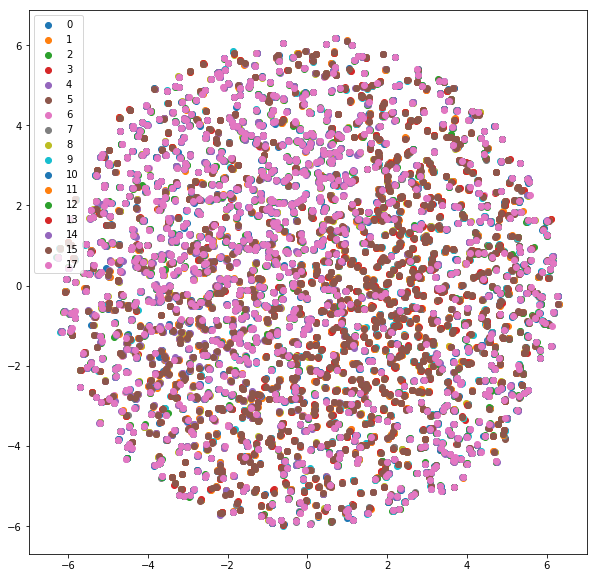

In [28]:
plot_2d_data(styles2d, Y)

In [29]:
isomap = Isomap()
styles_isomap = isomap.fit_transform(X_clf)

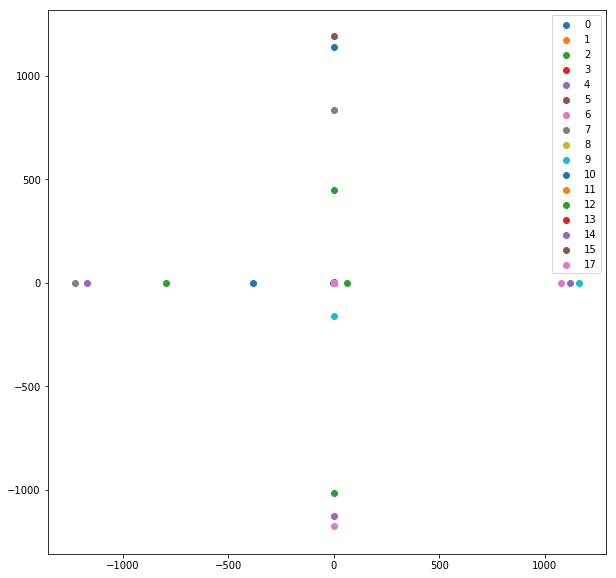

In [30]:
plot_2d_data(styles_isomap, Y)

'00_PopArt', '01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt'

Projecting 100D data to 2D


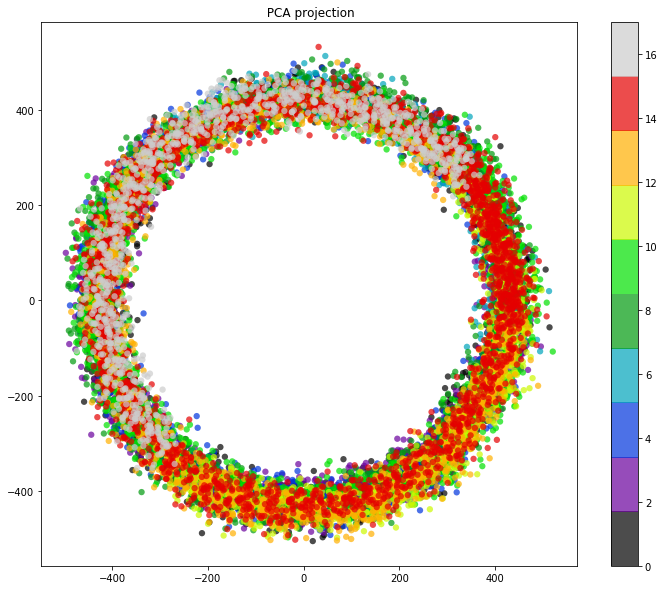

In [31]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
styles_pca = pca.fit_transform(X_clf)

print('Projecting {}D data to 2D'.format(X.shape[1]))

plt.figure(figsize=(12, 10))
plt.scatter(styles_pca[:, 0], styles_pca[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection');